***
# **Small-MOCCA: MLTrees Regression Training**

***
Feature exploration, optmization and training of traditional ML models for $M_{MMO}$ estimation.  

> Programs by J.Saavedra-Bastidas.
***

In [1]:
# General Libraries ---------------------------------------------------------------------------------------------#
import os
import sys
import argparse
import yaml
import torch 

import numpy  as np
import pandas as pd
#----------------------------------------------------------------------------------------------------------------#

In [2]:
# External functions and utilities ------------------------------------------------------------------------------#
from loguru          import logger
from dataclasses     import dataclass
from datetime        import datetime
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
#----------------------------------------------------------------------------------------------------------------#

In [3]:
os.chdir("../")

In [4]:
# Custom functions ----------------------------------------------------------------------------------------------#
from src.processing.features      import tabular_features
#from src.optim.optimizer          import SpaceSearch, SpaceSearchConfig
from src.utils.directory          import load_yaml_dict
from src.utils.visualize          import correlation_plot, residual_plot
from src.models.dltab.regressor   import DLTabularRegressor
#----------------------------------------------------------------------------------------------------------------#

In [5]:
# Set data partition paths --------------------------------------------------------------------------------------#
train_datapath = "datasets/paperv1/moccasurvey/0_fold/train.csv"
val_datapath   = "datasets/paperv1/moccasurvey/0_fold/val.csv"
test_datapath  = "datasets/paperv1/moccasurvey/test.csv"

# Set features and targets
contfeats = ["t/t_cc", "t/t_relax", "t/t_cross", "log(t_coll)", "M_tot/M_crit", 
             "log(R_h/R_core)", "log(R_tid/R_core)",
             "log(rho(R_h))",
             "Z"]

catfeats  = ["type_sim"]
target    = ["M_MMO/M_tot"]
#----------------------------------------------------------------------------------------------------------------#

In [6]:
# Prepare the training and validation data features -------------------------------------------------------------#
train_df = pd.read_csv(train_datapath, index_col=False)
val_df   = pd.read_csv(val_datapath, index_col=False)
test_df  = pd.read_csv(test_datapath, index_col=False)

# Extract features and target
feature_names  = contfeats + catfeats + target

# Training
feats_train, feats_names = tabular_features(train_df, names=feature_names, return_names=True, onehot=True)

# Identify continuous and categorical and target columns   
cont_columns   = [col for col in feats_train.columns if col in contfeats]
cat_columns    = [col for col in feats_train.columns if any(col.startswith(cf+"_") for cf in catfeats)] 
target_columns = [col for col in feats_train.columns if col in target]

# Extract numpy arrays
X_train = feats_train[cont_columns+cat_columns].astype(np.float32).to_numpy()
y_train = feats_train[target_columns].astype(np.float32).to_numpy().flatten() 

# Validation
feats_val, _ = tabular_features(val_df, names=feature_names, return_names=True, onehot=True)

X_val = feats_val[cont_columns+cat_columns].astype(np.float32).to_numpy()
y_val = feats_val[target_columns].astype(np.float32).to_numpy().flatten()

# Test  
feats_test, _ = tabular_features(test_df, names=feature_names, return_names=True, onehot=True)

X_test = feats_test[cont_columns+cat_columns].astype(np.float32).to_numpy()
y_test = feats_test[target_columns].astype(np.float32).to_numpy().flatten()

print(110*"_")
print(f"- Training features (Xtrain type={type(X_train)}): {len(X_train)} [{np.shape(X_train)}]")
print(f"- Training targets  (ytrain type={type(y_train)}): {len(y_train)} [{np.shape(y_train)}]")
print(110*"_")
print(f"- Validation features (Xval type={type(X_val)}): {len(X_val)} [{np.shape(X_val)}]")
print(f"- Validation targets  (yval type={type(y_val)}): {len(y_val)} [{np.shape(y_val)}]")
print(110*"_")
print(f"- Test features (Xtest type={type(X_test)}): {len(X_test)} [{np.shape(X_test)}]")
print(f"- Test targets  (ytest type={type(y_test)}): {len(y_test)} [{np.shape(y_test)}]")
print(110*"_")
#----------------------------------------------------------------------------------------------------------------#

______________________________________________________________________________________________________________
- Training features (Xtrain type=<class 'numpy.ndarray'>): 3397124 [(3397124, 12)]
- Training targets  (ytrain type=<class 'numpy.ndarray'>): 3397124 [(3397124,)]
______________________________________________________________________________________________________________
- Validation features (Xval type=<class 'numpy.ndarray'>): 417038 [(417038, 12)]
- Validation targets  (yval type=<class 'numpy.ndarray'>): 417038 [(417038,)]
______________________________________________________________________________________________________________
- Test features (Xtest type=<class 'numpy.ndarray'>): 242159 [(242159, 12)]
- Test targets  (ytest type=<class 'numpy.ndarray'>): 242159 [(242159,)]
______________________________________________________________________________________________________________


In [7]:
from src.utils.visualize import boxplot_features_with_points

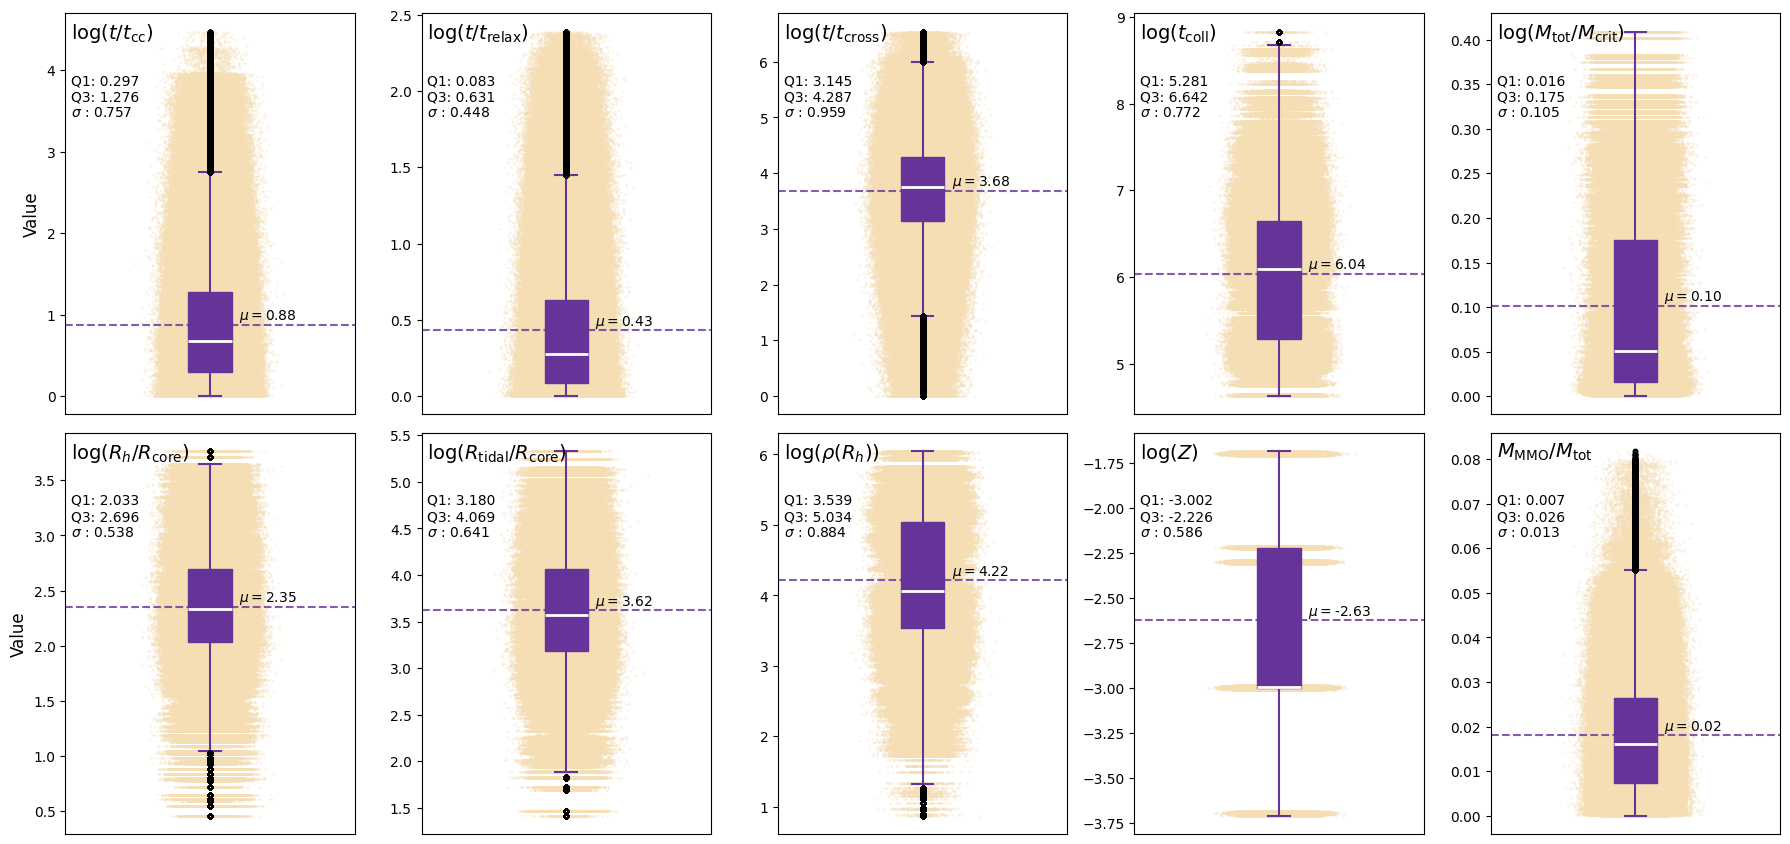

In [8]:
contvars     = cont_columns + target_columns
labels       = [feats_names[label] for label in contvars]

boxplot_features_with_points(features= feats_train[contvars], feature_names= labels,
                              path_save     = "",
                              figsize       = (18, 9),
                              name_file     = "",
                              dataset_name  = "moccasurvey",
                              nrows         = 2,
                              ncols         = 5,
                              point_color   = "wheat",
                              ifsave        = False,
                              ifshow        = True)

In [9]:
from src.utils.visualize import classic_correlogram

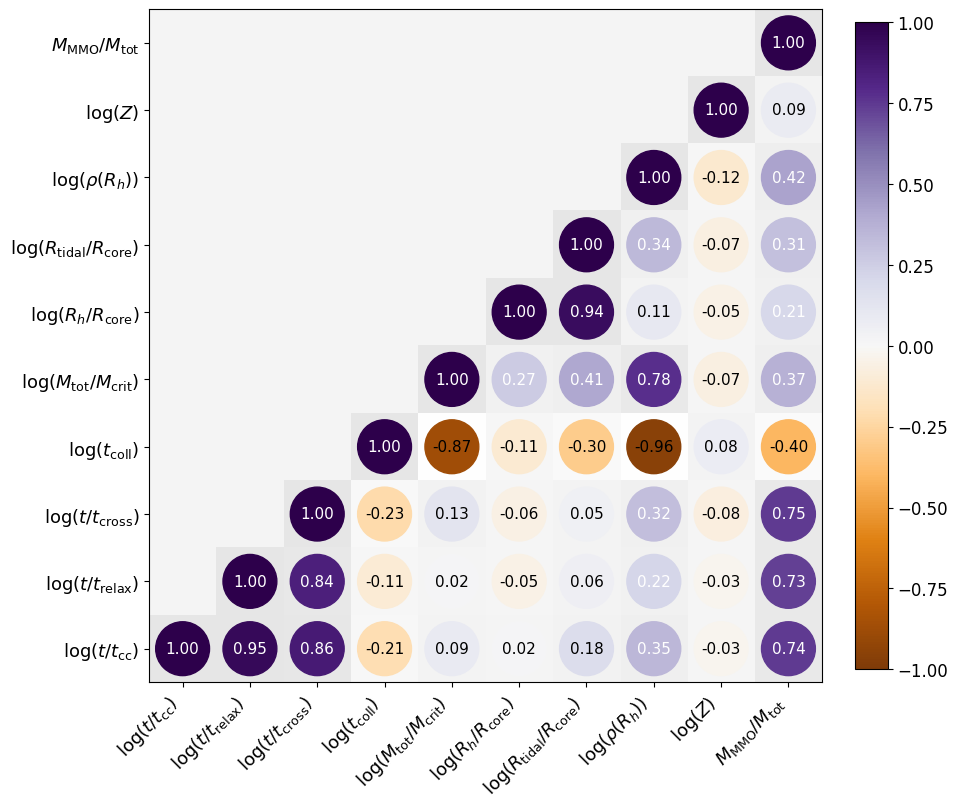

In [10]:
classic_correlogram(df=feats_train[contvars], method= "pearson", cmap= "PuOr",
                         path_save= None, name_file= None, dataset_name= None,
                         show= True, figsize= (10,10), labels=labels)

In [7]:
from torch.utils.data import TensorDataset, DataLoader

def make_dataloaders(
    X_train, y_train,
    X_val=None, y_val=None,
    batch_size=32,
    shuffle=True
):
    """
    Create PyTorch dataloaders for tabular regression.
    X_* must be numpy arrays (float32), y_* 1D arrays.
    """

    # --- Train ---
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)

    # --- Validation ---
    if X_val is not None and y_val is not None:
        X_val_t = torch.tensor(X_val, dtype=torch.float32)
        y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

        val_ds = TensorDataset(X_val_t, y_val_t)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    else:
        val_loader = None

    return train_loader, val_loader

In [44]:
name   = 'mlp'
params = {'in_features'   : 12,
          'hidden_layers' : [32, 64, 128, 128, 64, 32] ,
          'out_features'  : 1,
          'activation'    : 'relu',
          'dropout'       : 0.2 ,
          'batch_norm'    : True,
          'bias'          : True}
opt_name = 'adam'
opt_prs  = {'lr'           : 0.00001, 
            'betas'        : (0.9, 0.999),
            'eps'          : 1e-08,
            'weight_decay' : 0.0}


In [45]:
model = DLTabularRegressor(model_type=name, model_params=params, optimizer_name=opt_name,
                           optimizer_params = opt_prs,  
                           feat_names       = feats_names, 
                           n_jobs           = 10, 
                           device           = 'cuda:1',
                           use_amp          = True,
                           verbose          = True)

INFO: Initializing mlp model (device=cuda:1)...
SUCCESS: Successfully initialized mlp architecture
SUCCESS: Successfully initialized adam optimizer
SUCCESS: Enabled Automatic Mixed Precision (AMP) for training


In [46]:
train_loader, val_loader = make_dataloaders(X_train, y_train, X_val, y_val,
                                            batch_size=2048)

In [47]:
model.fit(train_loader, val_loader, epochs=50, loss_fn='huber', early_stopping_patience=5, verbose_epoch=1,
            checkpoint_path = './output/paperv1/mlp/big_size_arch/model.pth', 
            save_best_only  = True)

INFO: Starting training for 50 epochs (model=mlp, opt=adam)
INFO: Loss function : huber
INFO: Device        : cuda:1
SUCCESS: Model saved successfully to: ./output/paperv1/mlp/big_size_arch/model.pth
INFO: Model saved: Best val loss = 0.006602
INFO: Epoch [   1/50] - Train Loss: 0.234368 - Val Loss: 0.006602
SUCCESS: Model saved successfully to: ./output/paperv1/mlp/big_size_arch/model.pth
INFO: Model saved: Best val loss = 0.002016
INFO: Epoch [   2/50] - Train Loss: 0.101633 - Val Loss: 0.002016
SUCCESS: Model saved successfully to: ./output/paperv1/mlp/big_size_arch/model.pth
INFO: Model saved: Best val loss = 0.000583
INFO: Epoch [   3/50] - Train Loss: 0.059511 - Val Loss: 0.000583
SUCCESS: Model saved successfully to: ./output/paperv1/mlp/big_size_arch/model.pth
INFO: Model saved: Best val loss = 0.000289
INFO: Epoch [   4/50] - Train Loss: 0.041870 - Val Loss: 0.000289
SUCCESS: Model saved successfully to: ./output/paperv1/mlp/big_size_arch/model.pth
INFO: Model saved: Best val 

In [48]:
history = model.history

In [49]:
import matplotlib.pyplot as plt
from typing import Dict


def plot_training_history(
    history: Dict[str, list],
    patience: int,
    figsize: tuple = (7, 5),
    loss_name: str ="",
    logy: bool = True,
):
    """
    Plot training and validation loss curves with a vertical line
    indicating the epoch where the model was saved (early stopping).

    Parameters
    ----------
    history : dict
        Dictionary containing 'train_loss', 'val_loss', and 'epochs'.
    patience : int
        Epoch at which the model was saved.
    figsize : tuple, optional
        Figure size.
    logy : bool, optional
        Whether to use logarithmic scale on y-axis.
    """

    epochs     = history["epochs"]
    train_loss = history["train_loss"]
    val_loss   = history["val_loss"]

    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(
        epochs,
        train_loss,
        color='maroon',
        label="Training",
        linewidth=2,
    )
    ax.plot(
        epochs,
        val_loss,
        color='goldenrod',
        label="Validation",
        linewidth=2,
    )

    # Vertical line for saved model epoch
    ax.axvline(
        x=np.max(epochs)-patience,
        linestyle = "--",
        color     = "gray",
        linewidth = 1.5,
        label     = f"Saved model",
    )

    ax.set_xlabel("Epochs")
    ax.set_ylabel(f"Loss ({loss_name})")
    ax.set_title("Learning Curves", loc="left")

    if logy:
        ax.set_yscale("log")

    ax.legend()
    plt.tight_layout()
    plt.show()

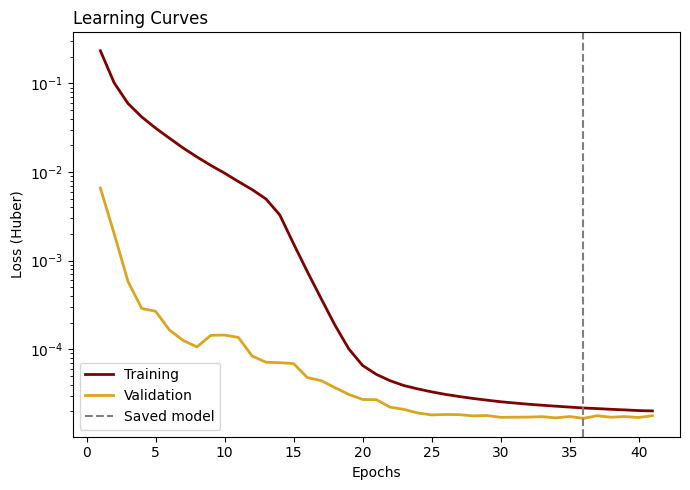

In [50]:
plot_training_history(history, patience=5, logy=True, loss_name="Huber")

In [51]:
# --- Convertir a tensor ---
y_pred = model.predict(X=X_test)

In [52]:
y_rescaled_test = y_test * (test_df["M_tot"])
y_rescaled_pred = np.clip(y_pred.flatten() * (test_df["M_tot"]), 0, None)

# Evaluation
mse  = mean_squared_error(y_rescaled_test, y_rescaled_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_rescaled_test, y_rescaled_pred)
r2   = r2_score(y_rescaled_test, y_rescaled_pred)

print(f"Test MSE  : {mse:.4f}")
print(f"Test RMSE : {rmse:.4f}")
print(f"Test MAE  : {mae:.4f}")
print(f"Test R2   : {r2:.4f}")

Test MSE  : 1805564.7708
Test RMSE : 1343.7131
Test MAE  : 1064.9383
Test R2   : 0.9580


In [36]:
save_path = './output/paperv1/mlp/mid_size_arch/'

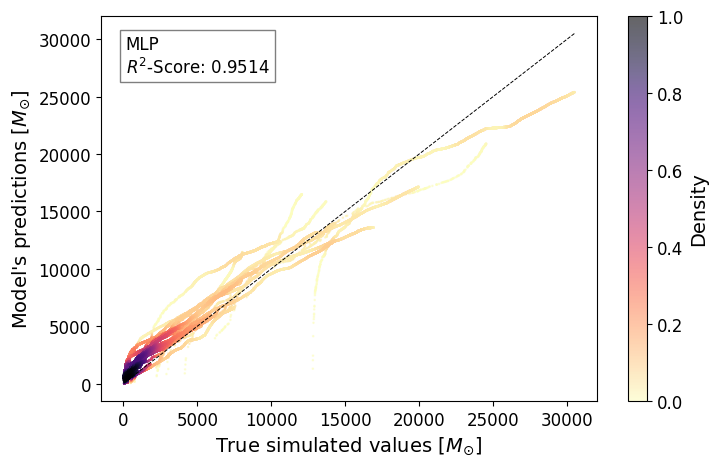

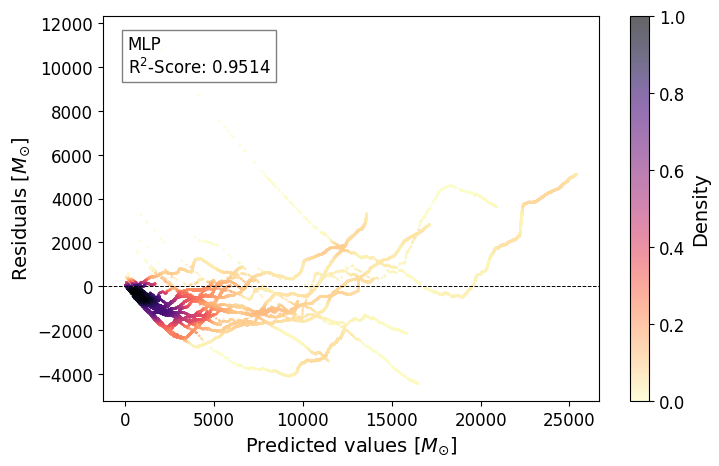

In [37]:
# Generate correlation plot

# Sampling 30% of the data
n_samples = int(len(y_test) * 0.3)
indexes   = np.random.choice(len(y_test.flatten()), size=n_samples, replace=False)

correlation_plot(predictions = y_rescaled_pred.to_numpy()[indexes],
                 true_values = y_rescaled_test.to_numpy()[indexes],
                 path_save   = save_path,
                 name_file   = f"model_mean_preds_corr",
                 model_name  = f"MLP",
                 cmap        = "magma_r",
                 scale       = None,
                 show        = True)

# Generate residual plot
residual_plot(predictions = y_rescaled_pred.to_numpy()[indexes],
              true_values = y_rescaled_test.to_numpy()[indexes],
              path_save   = save_path,
              name_file   = f"model_mean_preds_res",
              model_name  = f"MLP",
              cmap        = "magma_r",
              scale       = None,
              show        = True)

In [39]:
import random
dfs_by_sim = [group.sort_values("t").reset_index(drop=True)
              for _, group in test_df.groupby("or_sim_path")]
idx         = random.sample(range(len(dfs_by_sim)), 3)
print(idx)
list_of_example = []
for a in idx:
    simulation      = dfs_by_sim[a]
    feats_sim,   _  = tabular_features(simulation, names=feature_names, return_names=True, onehot=True)
    X_test_f        = feats_sim[cont_columns+cat_columns].astype(np.float32).to_numpy()
    y_pred          = model.predict(X=X_test_f)
    y_rescaled_pred = np.clip(y_pred.flatten() * (simulation["M_tot"]), 0, None)

    plotting_info = {'xaxis'  : {'values' : simulation['t'].to_numpy(),
                                 'label'  : r'$t$ [Myrs]'} ,
                     'yaxis'  : {'true_values' : simulation['M'].to_numpy() ,
                                 'pred_values' : y_rescaled_pred ,
                                 'label'       : r'$M_{\rm{MMO}}$ [M$_\odot$]'},
                     'iconds' : {r'M$_{\rm{tot}}$' : f"{simulation['M_tot'].values[0]:.3e} [M$_\odot$]"}
                    }
    
    list_of_example.append(plotting_info)

[18, 6, 24]


In [42]:
import matplotlib.pyplot as plt
import os
from typing import List, Dict, Optional


def plot_simulation_grid(
        subplot_data: List[Dict],
        n_rows: int =1,
        n_cols: int= 3,
        figsize: tuple = (16, 4),
        save_path: str = "./figures/sim_grid.jpg",
        show: bool = True):
    """
    Creates a figure with n_rows x n_cols subplots.
    
    Each subplot receives a dictionary with:
        - x_line, y_line: arrays for ax.plot
        - x_points, y_points: arrays for ax.scatter
        - title: optional title
        - x_label, y_label: axis labels (optional)
        - text_info: dict with key/value pairs to display inside the subplot
    """

    # --------------------------- Input validation --------------------------- #
    if len(subplot_data) != n_rows * n_cols:
        raise ValueError(
            f"Expected {n_rows * n_cols} dictionaries but received {len(subplot_data)}."
        )

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten to iterate easily

    # ----------------------------- Plot each subplot ----------------------------- #
    for ax, data in zip(axes, subplot_data):

        # Extract essential fields
        x_line = data.get("xaxis").get("values")
        y_line = data.get("yaxis").get("true_values")
        x_pts  = data.get("xaxis").get("values")
        y_pts  = data.get("yaxis").get("pred_values")

        # Plot: line + scatter
        if x_line is not None and y_line is not None:
            ax.plot(x_line, y_line, lw=1.5, color="black", ls="dashed", label="Ground truth" )

        if x_pts is not None and y_pts is not None:
            ax.scatter(x_pts, y_pts, s=2, marker='.', color="maroon", label='ML predictions')

        # Labels
        ax.set_xlabel(data["xaxis"]["label"], fontsize=12)
        ax.set_ylabel(data["yaxis"]["label"], fontsize=12)

        # scale
        ax.set_yscale('log')
        
        # Title
        if "title" in data:
            ax.set_title(data["title"], fontsize=13, loc="left")

        # Text table (like in your previous function)
        text_dict = data.get("iconds", {})
        if text_dict:
            text_lines = []
            for key, value in text_dict.items():
                if isinstance(value, float):
                    text_lines.append(f"{key}= {value:.3f}")
                else:
                    text_lines.append(f"{key}= {value}")

            ax.text(
                0.02, 0.98,
                "\n".join(text_lines),
                transform=ax.transAxes,
                fontsize=10,
                va="top",
                ha="left",
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=4)
            )
        ax.legend(loc='best')
    # ----------------------------- Save the figure ------------------------------ #
    save_dir = os.path.dirname(save_path)
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)

    plt.tight_layout()

    try:
        plt.savefig(save_path, dpi=500)
        if show:
            plt.show()
    except Exception as e:
        raise RuntimeError(f"Failed to save or display plot: {e}")
    finally:
        plt.close(fig)

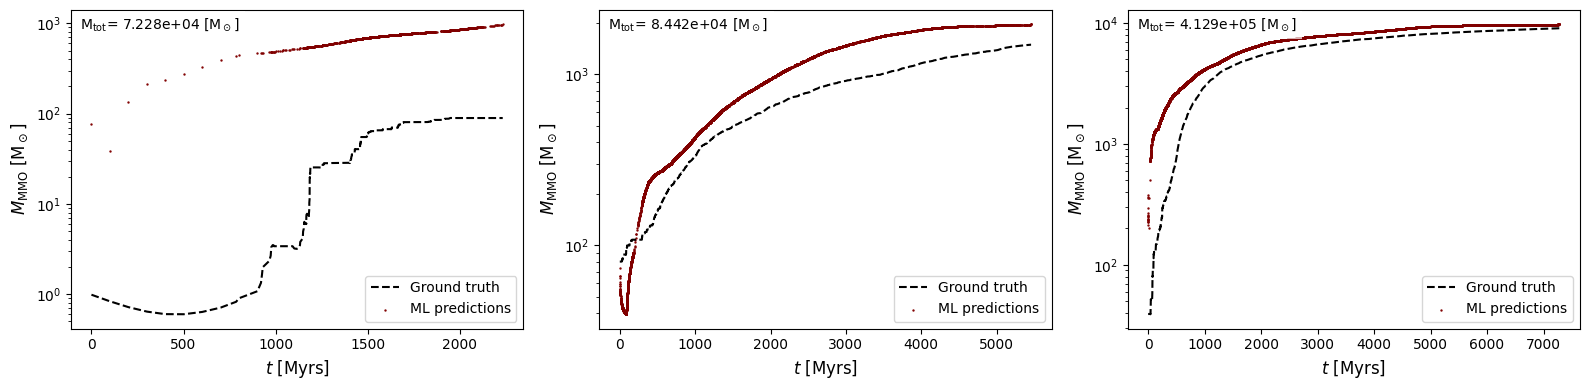

In [43]:
plot_simulation_grid(list_of_example)